## Analyzing Factors Affecting SBA-guaranteed Loan Default Rates

 The Small Business Administration (SBA) plays a crucial role in helping small businesses gain access to loans through its guarantee programs. However, loan defaults can pose significant risks to banks and borrowers, even with SBA assistance. In this presentation, we will analyze key factors affecting small business loan default rates. Through data analysis, we will examine the impact of industry, state-level economic factors, loan size, real estate backing, SBA guarantee, and business age on loan default rates. By gaining insights into these factors, banks can make informed decisions and implement risk mitigation measures to support responsible lending practices and promote sustainable small business lending.
 
 Import Libraries
 Import each of the data source and store it into DataFrames

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import uszipcode
from uszipcode import SearchEngine

In [9]:
df = pd.read_csv('SBAnational.csv')

C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\2640212651.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


### Data Cleaning, Formatting
taking a look at the data I'll be using for analysis.

checking for null values in the dataset

In [10]:
df.head(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"


In [11]:
df.shape

(899164, 27)

In [12]:
df.describe()

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,8.991640e+05,899164.000000,899164.000000,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,899164.000000,899164.000000
mean,4.772612e+09,53804.391241,398660.950146,110.773078,11.411353,1.280404,8.430376,10.797257,2753.725933,0.757748
std,2.538175e+09,31184.159152,263318.312759,78.857305,74.108196,0.451750,236.688165,237.120600,12758.019136,0.646436
min,1.000014e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.589758e+09,27587.000000,235210.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.361439e+09,55410.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,6.904627e+09,83704.000000,561730.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000
max,9.996003e+09,99999.000000,928120.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000


In [13]:
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [14]:
#Our target is  "MIS_Status" it has 2 variables: 
#Loan status charged off = CHGOFF, Paid in full = PIF
df.MIS_Status.value_counts()
# "PIF": 739609, CHGOFF: 157558, nan:1997
#We will try to not lose our rows with CHGOFF values while we are cleaning the dataset.

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

Next are City and State. As you can see, there are no NAs in Zip, so we can easily impute City and State uzing Zip values
First exclue some situation when zipcode =0,and cityt or state is null

In [15]:
mis1=df[df['Zip']==0]
mis1.shape

(283, 27)

In [16]:
mis2=mis1[(mis1.City.isnull()|mis1.State.isnull())]
mis2

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
49244,1380800010,TRYON COATS & LEATHER,JOHNSTOWN NY,NaN,0,KEYBANK NATIONAL ASSOCIATION,NY,0,18-May-66,1966,...,N,N,29-Mar-90,16-Aug-66,"$60,000.00",$0.00,CHGOFF,"$6,084.00","$60,000.00","$54,000.00"


In [17]:
# Looks like it is a mistake,put city and state in the same cell
df.iloc[49244,2]='JOHNSTOWN'
df.iloc[49244,3]='NY'
df.iloc[49244,3]=12095

In [18]:
#Creating conditions for a loop
missing_rows=df[(df.City.isnull()|df.State.isnull())].index

In [19]:
sr = SearchEngine()
for i in missing_rows:
    zipcode = sr.by_zipcode(df.iloc[i,4])
    df.iloc[i,2] = zipcode.major_city
    df.iloc[i,3] = zipcode.state 

AttributeError: 'NoneType' object has no attribute 'major_city'

In [20]:
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                      5
State                     3
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

Next, clean my dependent variable - MIS_Status drop NAs and change dtype from object to integer.
drop rows with NAs in City and State columns 


In [21]:
df=df.dropna(axis =0, subset=['State','MIS_Status','DisbursementDate' ])

Name is unique and useless and we can drop an entire column.
'ChgOffDate' corresponds to the date when a loan was declared to be in default. 
we have 739609 paid cases and 'ChgOffDate' has 736465 NAs 
seems like if credit is paid then there is an NA in this featue. default date = default case.
LoanNr_ChkDgt provide no useful value
So, we will just drop them.

In [23]:
df.drop(axis =1, columns=['Name','City', 'ChgOffDate', 'BankState','LoanNr_ChkDgt'], inplace=True)

In [24]:
df.isnull().sum()

State                   0
Zip                     0
Bank                 1504
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist              134
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4518
LowDoc               2546
DisbursementDate        0
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
dtype: int64

In [25]:
#Check data types of each feature
df.dtypes

State                 object
Zip                    int64
Bank                  object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [26]:
# check the currency fields that are currently being read as objects rather than floats.
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
0,"$60,000.00",$0.00,$0.00,"$60,000.00","$48,000.00"
1,"$40,000.00",$0.00,$0.00,"$40,000.00","$32,000.00"
2,"$287,000.00",$0.00,$0.00,"$287,000.00","$215,250.00"
3,"$35,000.00",$0.00,$0.00,"$35,000.00","$28,000.00"
4,"$229,000.00",$0.00,$0.00,"$229,000.00","$229,000.00"


In [27]:
# the '$' sign and commas are included.
# Remove '$', commas, and extra spaces from records in columns 
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].dtypes

DisbursementGross    object
BalanceGross         object
ChgOffPrinGr         object
GrAppv               object
SBA_Appv             object
dtype: object

In [28]:
#change the currency type from string to float
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']]=df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].astype(float)
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].dtypes

DisbursementGross    float64
BalanceGross         float64
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

In [29]:
# 'ApprovalFY' We have a mixture of integers and strings here, with one record including an 'A' as well.
df['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1982, 1966, 1983, 1973, 1984, 2007, 1985, 1986,
       1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010, 2011, 1992,
       1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977, 1976, '2004',
       '1994', '1979', '1976', '1975', '1974', '1977', '1981', '1982',
       '1983', '1984', '1978', '1980', '1968', '1976A', '1969', '1995',
       '1970', '2005', '1996', '1971', 1996, 1971], dtype=object)

In [30]:
#I change the column type to be string to replace "A"
df['ApprovalFY'] = df['ApprovalFY'].astype(str)
df['ApprovalFY'] = df['ApprovalFY'].str.replace('A', '')

In [31]:
# Change the type o Zip and UrbanRural to str (categorical) and ApprovalFY to int
df = df.astype({'Zip': 'str', 'UrbanRural': 'str', 'ApprovalFY': 'int'})                         

In [32]:
# Convert ApprovalDate and DisbursementDate columns to datetime values
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'])
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'])

In [33]:
# Create a new column with the industry the NAICS code represents
# Selects only the first two numbers of the NAICS code
# Maps the approprate industry to each record based on the first two digits of the NAICS code
df['Industry'] = df['NAICS'].astype('str').apply(lambda x: x[:2])
df['Industry'] = df['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})
df.Industry.isnull().sum()

201368

In [34]:
# Create column IsFranchise based on FranchiseCode column
df.loc[(df['FranchiseCode'] <= 1), 'IsFranchise'] = 0
df.loc[(df['FranchiseCode'] > 1), 'IsFranchise'] = 1

In [35]:
# Create Default  field based on MIS_Status where P I F = 0 and CHGOFF = 1 
df['Default'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['Default'].value_counts()

0    737757
1    157232
Name: Default, dtype: int64

In [36]:
df.isnull().sum()

State                     0
Zip                       0
Bank                   1504
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                134
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4518
LowDoc                 2546
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
Industry             201368
IsFranchise               0
Default                   0
dtype: int64

In [37]:
df.dtypes

State                        object
Zip                          object
Bank                         object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                    int32
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                   object
RevLineCr                    object
LowDoc                       object
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
Industry                     object
IsFranchise                 float64
Default                       int32
dtype: object

In [39]:
# Field for loans backed by Real Estate (loans with a term of at least 20 years)
df['RealEstate'] = np.where(df['Term'] >= 240, 1, 0)

### Portion of SBA Approval

<Axes: xlabel='MIS_Status', ylabel='SBA_AppvPct'>

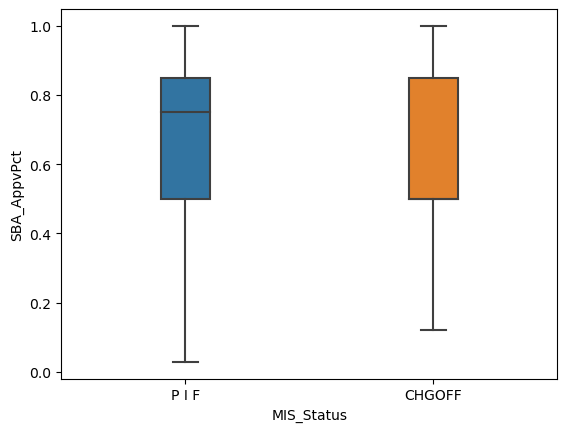

In [40]:
# Create SBA_AppvPct field
# Create a boxplot to compare the portion of SBA approvel variation in paid in full and defaulted loan
df['SBA_AppvPct'] = df['SBA_Appv'] / df['GrAppv']
sns.boxplot(y=df['SBA_AppvPct'], x=df['MIS_Status'], width=0.2, )  

In [41]:
# Filter data for paid-in-full (PIF) and defaulted (CHGOFF) loans
pif_loans = df[df['MIS_Status'] == 'P I F']
chgoff_loans = df[df['MIS_Status'] == 'CHGOFF']


In [42]:
#Calculate basic statistics for SBA-guaranteed portion for paid-in-full loans
pif_stats = pif_loans['SBA_AppvPct'].describe()
pif_stats

count    737757.000000
mean          0.724152
std           0.172487
min           0.028140
25%           0.500000
50%           0.750000
75%           0.850000
max           1.000000
Name: SBA_AppvPct, dtype: float64

In [43]:
# Calculate basic statistics for SBA-guaranteed portion for defaulted loans
chgoff_stats = chgoff_loans['SBA_AppvPct'].describe()
chgoff_stats

count    157232.000000
mean          0.643596
std           0.163406
min           0.121900
25%           0.500000
50%           0.500000
75%           0.850000
max           1.000000
Name: SBA_AppvPct, dtype: float64

Distribution of this ratio for loans that were paid in full and loans that defaulted, disbursed between 1987 and 2014. The boxplots indicate that loans that were paid in full tend to have a slightly higher SBA-guaranteed percentage, as shown by the higher mean portion for paid-in-full loans.
It is important to note that the median (50th percentile) is not displayed in the boxplots for defaulted loans because 54% of these loans have half of the loan amount guaranteed by the SBA (portion D 0.5). This means that there is no difference in the 25th, and 50th percentiles, as they are all equal to 0.5, indicating that a significant portion of defaulted loans had 50% of the loan amount guaranteed by the SBA.

### Correlation Matrix

C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\4146709842.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


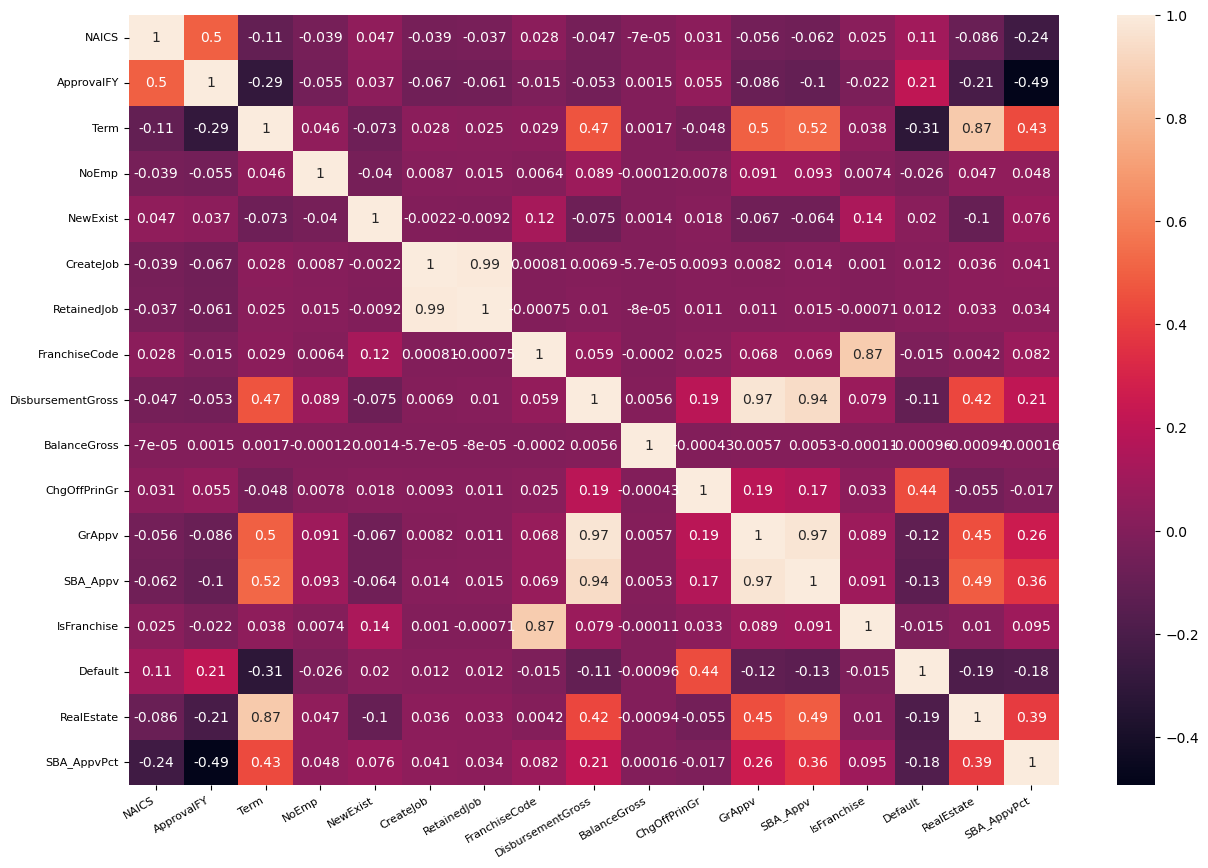

In [44]:
# Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = df.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

### Disbursement Gross

In [45]:
#Calculate basic statistics for gross disbursement pay in full and defaulted
df.groupby('MIS_Status').DisbursementGross.describe()

,count,mean,std,min,25%,50%,75%,max
MIS_Status,,,,,,,,
CHGOFF,157232.0,132500.312386,211894.767677,4000.0,27500.0,61473.0,140000.0,4362157.0
P I F,737757.0,216583.440400,299577.841683,4000.0,49000.0,100000.0,257000.0,11446325.0


C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\2671021470.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_industrySum = df2.groupby(['Industry']).sum().sort_values('DisbursementGross', ascending=False)
C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\2671021470.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_industryAve = df2.groupby(['Industry']).mean().sort_values('DisbursementGross', ascending=False)
C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\2671021470.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_industrySum.index, rotati

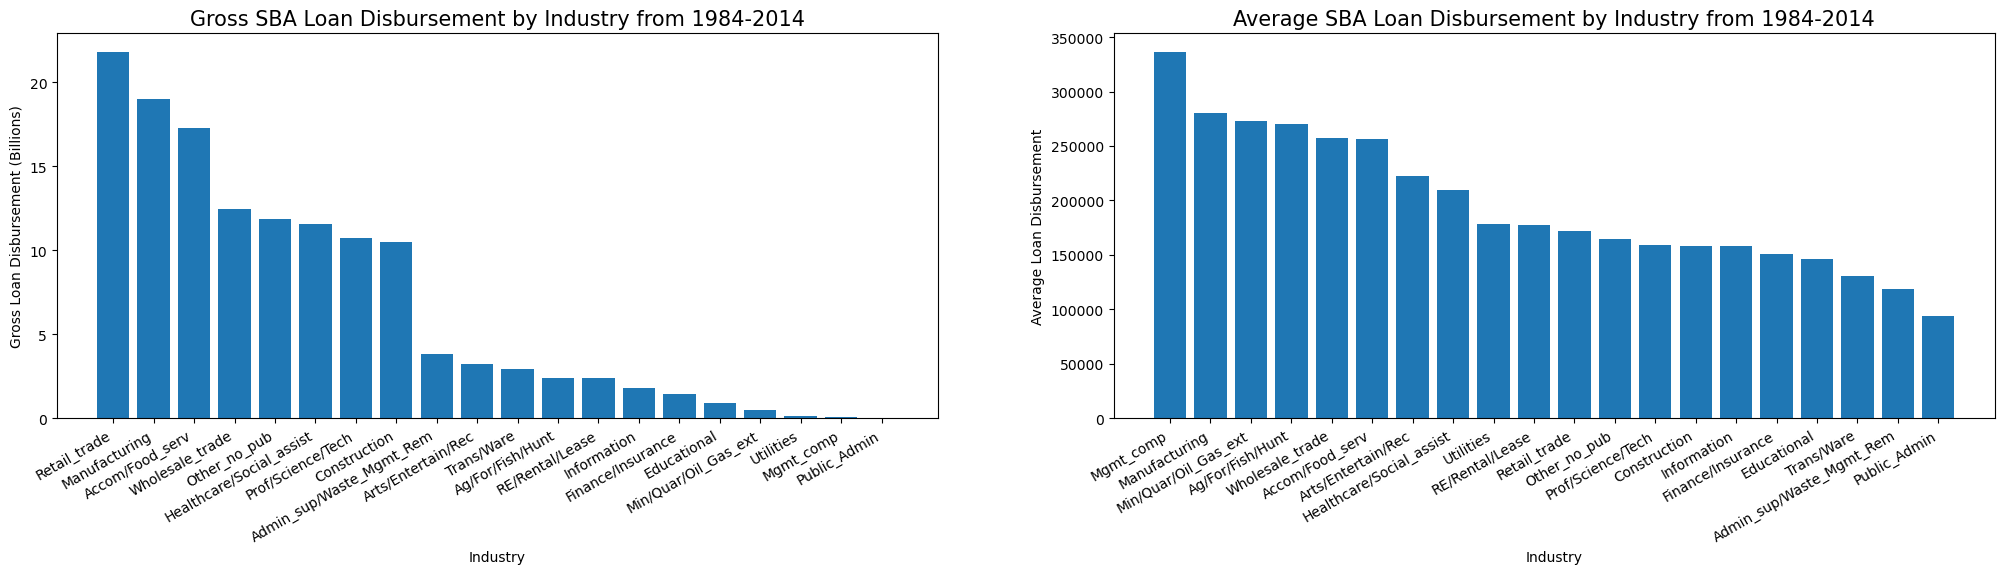

In [46]:
# Total/Average disbursed loan amount by industry
# Create a groupby object on Industry for use in visualization
df2= df.dropna(axis=0, subset=['Industry'])
# Data frames based on groupby by Industry looking at aggregate and average values
df_industrySum = df2.groupby(['Industry']).sum().sort_values('DisbursementGross', ascending=False)
df_industryAve = df2.groupby(['Industry']).mean().sort_values('DisbursementGross', ascending=False)
# Establish figure for placing bar charts side-by-side
fig = plt.figure(figsize=(25, 5))
# Add subplots to figure to build 1x2 grid and specify position of each subplot
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.bar(df_industrySum.index, df_industrySum['DisbursementGross'] / 1000000000)
ax1.set_title('Gross SBA Loan Disbursement by Industry from 1984-2014', fontsize=15)
ax1.set_xlabel('Industry')
ax1.set_ylabel('Gross Loan Disbursement (Billions)')
ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)
ax2.bar(df_industryAve.index, df_industryAve['DisbursementGross'])
ax2.set_title('Average SBA Loan Disbursement by Industry from 1984-2014', fontsize=15)
ax2.set_xlabel('Industry')
ax2.set_ylabel('Average Loan Disbursement')
ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)
plt.show()

The size of the loan can be an important factor in loan performance.

·      Larger loans may indicate an established and expanding business, which can increase the likelihood of loan repayment.

·      Retail trade and Manufacturing industries had significantly higher loan funds compared to other industries, indicating a higher demand for SBA-guaranteed loans in these sectors.

·      Agriculture, forestry, fishing and hunting, Mining, quarrying, and oil and gas extraction, and Management of companies and enterprises had a smaller total loan amount relative to other industries, but they had the highest average loan amount.

·      This suggests that these industries may have had a small number of large loans, potentially indicating unique characteristics or financing needs within these sectors.



### Industry Type

In [47]:
# Check Default percentage by Industry
df3=df2.groupby(['Industry']).MIS_Status.value_counts().unstack()
df_ind = df2.groupby(['Industry', 'MIS_Status'])['Industry'].count().unstack('MIS_Status')
df_ind['Default_Rate_ind'] = df_ind['CHGOFF']/(df_ind['CHGOFF'] + df_ind['P I F'])
df_ind

MIS_Status,CHGOFF,P I F,Default_Rate_ind
Industry,,,
Accom/Food_serv,14861,52546,0.220467
Admin_sup/Waste_Mgmt_Rem,7646,24754,0.235988
Ag/For/Fish/Hunt,811,8171,0.090292
Arts/Entertain/Rec,3012,11573,0.206514
Construction,15449,50835,0.233073
Educational,1548,4831,0.242671
Finance/Insurance,2689,6748,0.284942
Healthcare/Social_assist,5732,49361,0.104042
Information,2818,8514,0.248676


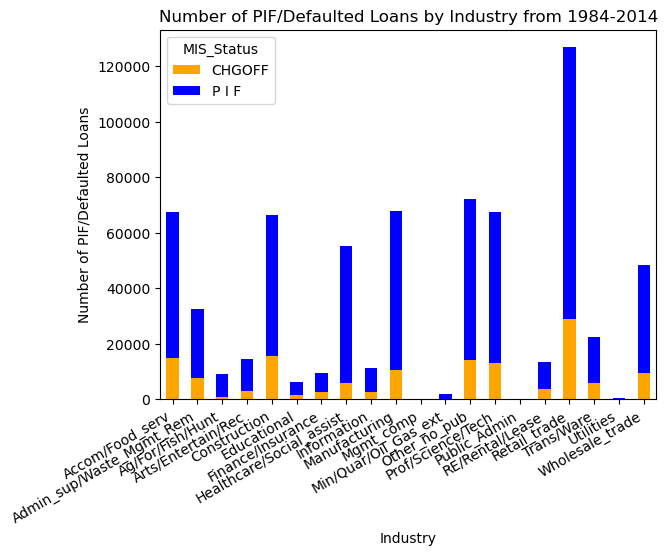

In [48]:
# Paid in full and defaulted loans
# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable
df3.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Number of PIF/Defaulted Loans by Industry from 1984-2014')
plt.xlabel('Industry')
plt.ylabel('Number of PIF/Defaulted Loans')
plt.xticks( rotation=30, horizontalalignment='right', fontsize=10)
plt.show()

 Consideration of industry-specific factors is important when analyzing variation in SBA-guaranteed loan default rates.
       Variation in industry default rates can be attributed to the cyclical nature of demand for products or services.
·      Low default rates (8-10%) are observed in industries like mining, oil and gas exploration, agriculture, and security holding companies.
·      Higher default rates (28-29%) are observed in industries like retail trade and financial institutions.
·      Retail trade, other services (except public administration), and manufacturing have the highest number of loans during the sample period, but loan count does not correlate with default rate.


### Location

In [50]:
# Check Default percentage by States
df4=df2.groupby(['State']).MIS_Status.value_counts().unstack()
df_State = df2.groupby(['State', 'MIS_Status'])['MIS_Status'].count().unstack('MIS_Status')
df_State['Default_Rate_State'] = df_State['CHGOFF']/(df_State['CHGOFF'] + df_State['P I F'])
df_State

MIS_Status,CHGOFF,P I F,Default_Rate_State
State,,,
AK,132.0,1321.0,0.090847
AL,1180.0,4440.0,0.209964
AP,1.0,NaN,NaN
AR,849.0,3566.0,0.192299
AZ,3406.0,10787.0,0.239977
CA,22578.0,78997.0,0.222279
CO,3307.0,12597.0,0.207935
CT,1508.0,8144.0,0.156237
DC,363.0,973.0,0.271707


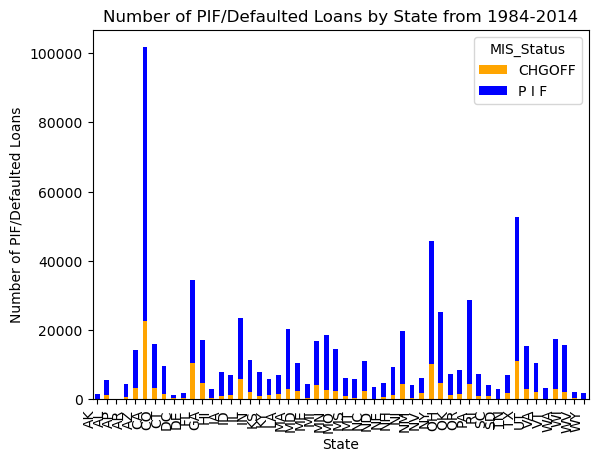

In [51]:
# Number of Paid in full and defaulted loans by State
df4.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Number of PIF/Defaulted Loans by State from 1984-2014')
plt.xlabel('State')
plt.ylabel('Number of PIF/Defaulted Loans')
plt.xticks( horizontalalignment='right', fontsize=10)
plt.show()

State-level economic factors can impact default rates.

·      Florida (30.9%) and Nevada (27.8%) have the highest default percentages, while Wyoming (6.69%) and Montana (7.16%) have the lowest rates.

·      California (101,575), Texas (52,537), and New York (45,588) have the highest loan volumes, likely reflecting states with strong economic activity.

·      Loan volume has generally increased over time until 2008.


### Real Estate

In [53]:
# Check Default percentage for loans backed by Real Estate
df5= df2.groupby(['RealEstate', 'MIS_Status'])['RealEstate'].count().unstack('MIS_Status')
df5['Def_Percent'] =df5['CHGOFF']/(df5['CHGOFF'] + df5['P I F'])
df5

MIS_Status,CHGOFF,P I F,Def_Percent
RealEstate,,,
0,138973,456222,0.233492
1,1623,96803,0.016490


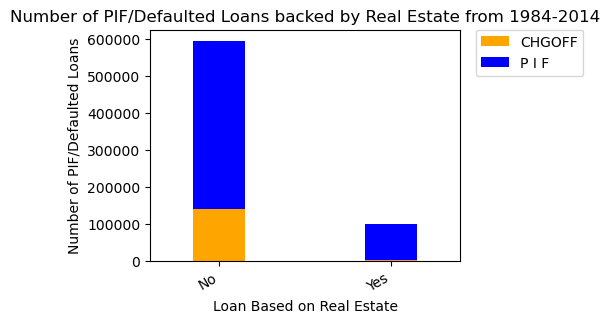

In [54]:
# Paid in full and defaulted loans backed by Real Estate
df5.drop(axis =1, columns=['Def_Percent']).plot(kind='bar', stacked=True, color=['orange', 'blue'],
        figsize=(4,3), width = 0.3)
plt.title('Number of PIF/Defaulted Loans backed by Real Estate from 1984-2014')
plt.xlabel('Loan Based on Real Estate')
plt.ylabel('Number of PIF/Defaulted Loans')
plt.xticks(df5.index, labels=['No', 'Yes'], rotation=30, horizontalalignment='right', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Real Estate Backing: A Key Indicator of Small Business Loan Default Rate

·      Loans backed by real estate are considered a key risk indicator in small business lending.

·      Loans with real estate backing have a significantly lower default rate of 1.65% compared to loans without real estate backing, which have a higher default rate of 23.35%.

·      There is a relatively negligible difference in default rates between loans to new businesses (≤ 2 years old) and established businesses (> 2 years old).

·      Default rate for new businesses is 21.33% while the rate for established businesses is slightly lower at 19.89%.

·      However, the dataset indicates that a higher portion of loans with real estate backing are associated with larger loan amounts, highlighting the potential impact of real estate backing on loan size and default risk.


### Great Recession

C:\Users\YYJJ\AppData\Local\Temp\ipykernel_24524\1142070334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['GreatRecession'] = np.where(((df2['DisbursementDate']>=start) & (df2['DisbursementDate'] <= end)), 1,0)


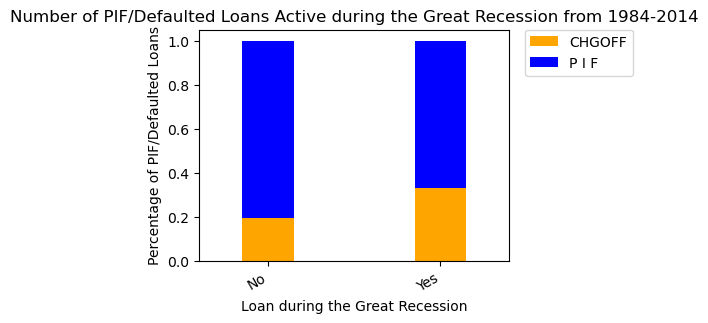

In [55]:
# Check Default percentage for loans active during the Great Recession
#recession time create 'Great Recession' Field for loans active during the Great Recession (2007-2009)
start='2007-12-01'
end='2009-06-01'
df2['GreatRecession'] = np.where(((df2['DisbursementDate']>=start) & (df2['DisbursementDate'] <= end)), 1,0)
df_re=df2.groupby(['GreatRecession']).MIS_Status.value_counts(normalize = True).unstack()
df_re.plot(kind='bar', stacked=True, color=['orange', 'blue'], figsize=(4,3), width = 0.3)
plt.title('Number of PIF/Defaulted Loans Active during the Great Recession from 1984-2014')
plt.xlabel('Loan during the Great Recession')
plt.ylabel('Percentage of PIF/Defaulted Loans')
plt.xticks(df5.index, labels=['No', 'Yes'], rotation=30, horizontalalignment='right', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [76]:
recession=df2['GreatRecession']==1
nonrecession=df2['GreatRecession']==0
df6=df2[recession].groupby(['Industry', 'MIS_Status'])['Industry'].count().unstack('MIS_Status')
df6['Def_Percent'] = df6['CHGOFF']/(df6['CHGOFF'] + df6['P I F'])
df7=df2[nonrecession].groupby(['Industry', 'MIS_Status'])['Industry'].count().unstack('MIS_Status')
df7['Def_Percent'] = df7['CHGOFF']/(df7['CHGOFF'] + df7['P I F'])
df6

MIS_Status,CHGOFF,P I F,Def_Percent
Industry,,,
Accom/Food_serv,1903,3938,0.325800
Admin_sup/Waste_Mgmt_Rem,867,1656,0.343639
Ag/For/Fish/Hunt,61,325,0.158031
Arts/Entertain/Rec,390,774,0.335052
Construction,1878,3586,0.343704
Educational,236,436,0.351190
Finance/Insurance,332,483,0.407362
Healthcare/Social_assist,669,2956,0.184552
Information,335,502,0.400239


In [77]:
df7


MIS_Status,CHGOFF,P I F,Def_Percent
Industry,,,
Accom/Food_serv,12958,48608,0.210473
Admin_sup/Waste_Mgmt_Rem,6779,23098,0.226897
Ag/For/Fish/Hunt,750,7846,0.087250
Arts/Entertain/Rec,2622,10799,0.195365
Construction,13571,47249,0.223134
Educational,1312,4395,0.229893
Finance/Insurance,2357,6265,0.273370
Healthcare/Social_assist,5063,46405,0.098372
Information,2483,8012,0.236589


Small business loans are influenced by the overall economy, and during economic recessions, there tends to be an increase in small business loan defaults.

·      Loans that were active during the Great Recession (December 2007 to June 2009) had a higher default rate of 33.02%, compared to loans that were not active during the recession, which had a default rate of 19.28%.

·      Certain industries were found to be more vulnerable to loan defaults during recessionary periods.

·      Industries with initially low default rates experienced a significant increase, sometimes three times or more, in loan defaults during the recession.

·      In contrast, industries with initially high default rates saw a relatively smaller increase of around 50%.

·      This suggests that the impact of economic recessions on loan defaults can vary by industry, with some industries being more susceptible to economic downturns than others.

